# Grok銘柄パターン分析
## 目的: プロンプト改善のための騰落要因分析

- なぜ上がったのか？（勝ちパターン）
- なぜ下がったのか？（負けパターン）
- 選定理由・タグとパフォーマンスの関係
- マーケット環境との相関

In [19]:
import sys
from pathlib import Path

# grok_trending_performance ディレクトリ
GROK_DIR = Path.cwd().parent
SCRIPTS_DIR = GROK_DIR / 'scripts'

if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))

# プロジェクトルート（dash_plotly）
ROOT = GROK_DIR.parent.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 日本語フォント設定を最優先で適用
matplotlib.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Hiragino Kaku Gothic ProN', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# matplotlibのフォントキャッシュをクリア
fm._load_fontmanager(try_read_cache=False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

from load_data import DataLoader

loader = DataLoader()
print("✓ ライブラリ読み込み完了")
print(f"✓ 使用フォント: {plt.rcParams['font.sans-serif'][0]}")

Matplotlib is building the font cache; this may take a moment.


✓ ライブラリ読み込み完了
✓ 使用フォント: Arial


## 1. Grok銘柄データ読み込み

In [20]:
# Grokバックテストアーカイブ
archive = loader.load_grok_archive()

print(f"総レコード数: {len(archive)}")
print(f"期間: {archive['backtest_date'].min()} ～ {archive['backtest_date'].max()}")
print(f"ユニーク日数: {archive['backtest_date'].nunique()}")
print(f"ユニーク銘柄数: {archive['ticker'].nunique()}")

print("\n【カラム】")
print(archive.columns.tolist())

print("\n【サンプル】")
archive.head(3)

✓ Grok archive loaded: 24 records
総レコード数: 24
期間: 2025-10-28 00:00:00 ～ 2025-10-30 00:00:00
ユニーク日数: 2
ユニーク銘柄数: 18

【カラム】
['ticker', 'stock_name', 'selection_score', 'grok_rank', 'reason', 'selected_time', 'backtest_date', 'buy_price', 'sell_price', 'phase1_return', 'phase1_win', 'prompt_version', 'profit_per_100_shares', 'morning_high', 'morning_low', 'morning_volume', 'max_gain_pct', 'max_drawdown_pct']

【サンプル】


,ticker,stock_name,selection_score,grok_rank,reason,selected_time,backtest_date,buy_price,sell_price,phase1_return,phase1_win,prompt_version,profit_per_100_shares,morning_high,morning_low,morning_volume,max_gain_pct,max_drawdown_pct
0,4592.T,サンバイオ,160.0,1,2025年10月29日夜に再生医療分野での治験進展ニュースが報道。Xで「2025年10月30...,23:00,2025-10-30,2720.0,2782.0,0.022794,True,v1_0_baseline,6200.0,2792.0,2709.0,571800.0,0.028740,-0.001842
1,3914.T,JIG-SAW,158.0,2,2025年10月29日引け後にAI関連の新サービス開始をIR発表。Xで「2025年10月30...,23:00,2025-10-30,3350.0,3500.0,0.044776,True,v1_0_baseline,15000.0,3500.0,3215.0,71200.0,0.043219,-0.041729
2,4575.T,キャンバス,155.0,3,2025年10月29日夜に抗がん剤開発の進展ニュースが報道。Xで「2025年10月30日仕込...,23:00,2025-10-30,856.0,856.0,0.000000,False,v1_0_baseline,0.0,871.0,850.0,118300.0,0.018713,-0.005848


## 2. 基礎統計: 勝ち vs 負け

In [21]:
# 勝ち負けで分類
winners = archive[archive['phase1_win'] == True]
losers = archive[archive['phase1_win'] == False]

print("【基礎統計】")
print(f"勝ち: {len(winners)} 銘柄 ({len(winners)/len(archive)*100:.1f}%)")
print(f"負け: {len(losers)} 銘柄 ({len(losers)/len(archive)*100:.1f}%)")
print(f"\n平均リターン:")
print(f"  勝ち: +{winners['phase1_return'].mean()*100:.2f}%")
print(f"  負け: {losers['phase1_return'].mean()*100:.2f}%")
print(f"  全体: {archive['phase1_return'].mean()*100:.2f}%")

【基礎統計】
勝ち: 10 銘柄 (41.7%)
負け: 13 銘柄 (54.2%)

平均リターン:
  勝ち: +1.36%
  負け: -0.85%
  全体: 0.11%


## 3. タグ別パフォーマンス分析

【プロンプトバージョン別パフォーマンス】
                平均リターン(%)  勝率(%)  件数
prompt_version                      
v1_0_baseline        0.11  41.67  23


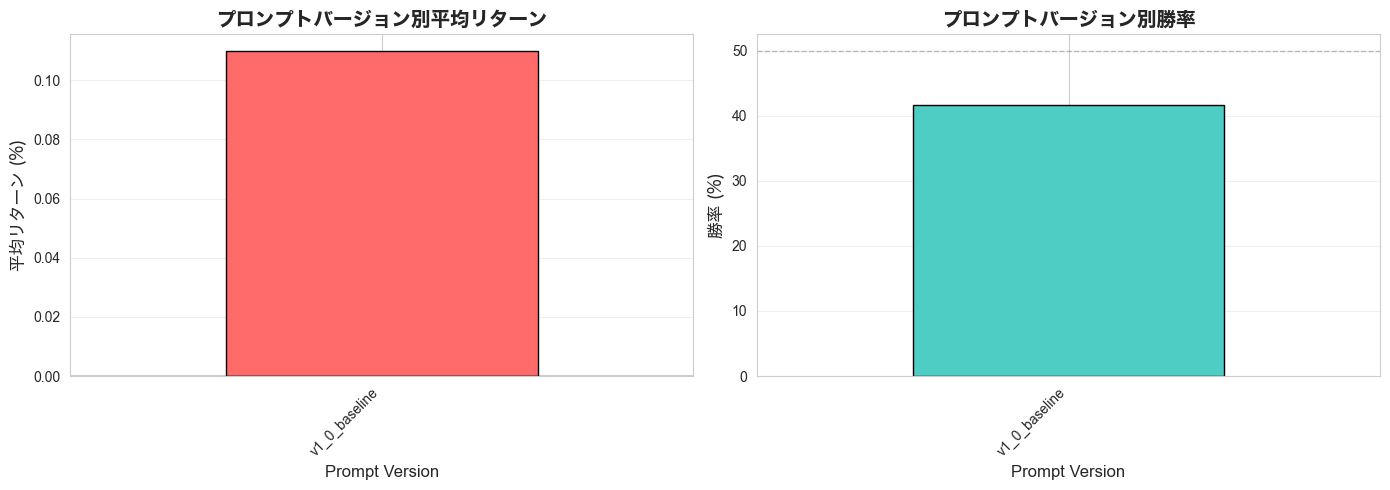

In [22]:
# プロンプトバージョン別パフォーマンス分析
if 'prompt_version' in archive.columns:
    prompt_summary = archive.groupby('prompt_version').agg({
        'phase1_return': ['mean', 'count'],
        'phase1_win': lambda x: (x == True).mean()
    }).round(4)
    
    prompt_summary.columns = ['平均リターン', '件数', '勝率']
    prompt_summary['平均リターン(%)'] = prompt_summary['平均リターン'] * 100
    prompt_summary['勝率(%)'] = prompt_summary['勝率'] * 100
    prompt_summary = prompt_summary[['平均リターン(%)', '勝率(%)', '件数']]
    
    print("【プロンプトバージョン別パフォーマンス】")
    print(prompt_summary)
    
    # 可視化
    if len(prompt_summary) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # 平均リターン
        ax1 = axes[0]
        colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in prompt_summary['平均リターン(%)']]
        prompt_summary['平均リターン(%)'].plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax1.set_ylabel('平均リターン (%)', fontsize=12, fontfamily='Hiragino Sans')
        ax1.set_title('プロンプトバージョン別平均リターン', fontsize=14, fontweight='bold', fontfamily='Hiragino Sans')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_xlabel('Prompt Version', fontsize=12)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # 勝率
        ax2 = axes[1]
        colors = ['#FF6B6B' if x >= 50 else '#4ECDC4' for x in prompt_summary['勝率(%)']]
        prompt_summary['勝率(%)'].plot(kind='bar', ax=ax2, color=colors, edgecolor='black')
        ax2.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax2.set_ylabel('勝率 (%)', fontsize=12, fontfamily='Hiragino Sans')
        ax2.set_title('プロンプトバージョン別勝率', fontsize=14, fontweight='bold', fontfamily='Hiragino Sans')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_xlabel('Prompt Version', fontsize=12)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('../outputs/figures/grok_prompt_performance.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("⚠️ prompt_versionカラムが存在しません")

## 4. 選定理由別パフォーマンス分析

In [23]:
# reasonカラムの分析
if 'reason' in archive.columns:
    # reasonから特徴的なキーワードを抽出
    keywords = ['材料', '決算', '業績', '発表', '上方修正', '下方修正', 'IR', '提携', 
                '買収', '新製品', '新技術', '増配', '株式分割', '自社株買い']
    
    keyword_performance = []
    
    for keyword in keywords:
        mask = archive['reason'].str.contains(keyword, na=False, case=False)
        matched = archive[mask]
        
        if len(matched) > 0:
            keyword_performance.append({
                'キーワード': keyword,
                '件数': len(matched),
                '平均リターン(%)': matched['phase1_return'].mean() * 100,
                '勝率(%)': (matched['phase1_win'] == True).mean() * 100
            })
    
    if keyword_performance:
        kw_df = pd.DataFrame(keyword_performance)
        kw_df = kw_df[kw_df['件数'] >= 2]  # 2件以上
        kw_df = kw_df.sort_values('平均リターン(%)', ascending=False)
        
        print("【選定理由キーワード別パフォーマンス】")
        print(kw_df.round(2))
    else:
        print("⚠️ キーワードマッチなし")
else:
    print("⚠️ reasonカラムが存在しません")

【選定理由キーワード別パフォーマンス】
  キーワード  件数  平均リターン(%)  勝率(%)
2    提携   4       0.07  50.00
0    発表  20       0.04  45.00
1    IR  17      -0.05  41.18


## 5. 勝ちパターン vs 負けパターンの詳細分析

In [24]:
print("【勝ちパターンTop 10】")
print("="*80)
top_winners = winners.nlargest(10, 'phase1_return')[['ticker', 'stock_name', 'phase1_return', 'reason']]
for idx, row in top_winners.iterrows():
    print(f"\n{row['ticker']} - {row['stock_name']}")
    print(f"  リターン: +{row['phase1_return']*100:.2f}%")
    print(f"  理由: {row['reason'][:100]}..." if len(str(row['reason'])) > 100 else f"  理由: {row['reason']}")

print("\n\n【負けパターンWorst 10】")
print("="*80)
worst_losers = losers.nsmallest(10, 'phase1_return')[['ticker', 'stock_name', 'phase1_return', 'reason']]
for idx, row in worst_losers.iterrows():
    print(f"\n{row['ticker']} - {row['stock_name']}")
    print(f"  リターン: {row['phase1_return']*100:.2f}%")
    print(f"  理由: {row['reason'][:100]}..." if len(str(row['reason'])) > 100 else f"  理由: {row['reason']}")

【勝ちパターンTop 10】

3914.T - JIG-SAW
  リターン: +4.48%
  理由: 2025年10月29日引け後にAI関連の新サービス開始をIR発表。Xで「2025年10月30日寄付買い」の投稿が150件以上拡散。出来高は20日平均の3.8倍、ATR 6.1%、時価総額約180億円の...

4417.T - グローバルセキュリティエキスパート
  リターン: +2.55%
  理由: 2025年10月29日引け後にセキュリティ関連の大型契約IR発表。Xで「明日買い」の投稿が100件以上。出来高3.7倍、ATR 5.4%、時価総額約190億円。

4592.T - サンバイオ
  リターン: +2.28%
  理由: 2025年10月29日夜に再生医療分野での治験進展ニュースが報道。Xで「2025年10月30日ストップ高期待」の投稿が130件以上。出来高5.1倍、ATR 7.2%、時価総額約400億円。

3625.T - テックファームHD
  リターン: +1.48%
  理由: 2025年10月29日引け後にデジタル決済分野での業務提携を発表。Xで「明日ストップ高狙い」の言及が急増（約120件）。出来高4.5倍、ATR 5.7%、時価総額約250億円。

3927.T - フーバーブレイン
  リターン: +0.81%
  理由: 2025年10月29日引け後にサイバーセキュリティ製品の受注IR発表。Xで「2025年10月30日注目銘柄」として言及80件超。出来高3.1倍、ATR 4.9%、時価総額約220億円。

3936.T - グローバルウェイ
  リターン: +0.62%
  理由: 2025年10月27日引け後にクラウドサービス拡大のIR発表。Xで「2025年10月28日仕込む」の言及が100件以上。2025年10月27日の出来高は平均の3.6倍、直近5日ATR 5.7%。時価総...

3031.T - ラクーンHD
  リターン: +0.57%
  理由: 2025年10月27日引け後にEC新サービスのIR発表。その後のXで「2025年10月28日寄付買い」の投稿が急増（150件以上）。2025年10月27日の出来高は20日平均の4.5倍、直近5日ATR...

3929.T - ソーシャルワイヤー
  リターン: +0.

## 6. マーケット環境との相関分析

✓ Index prices loaded: 149770 rows, interval=1d
【日経平均との相関】
相関係数: 0.458


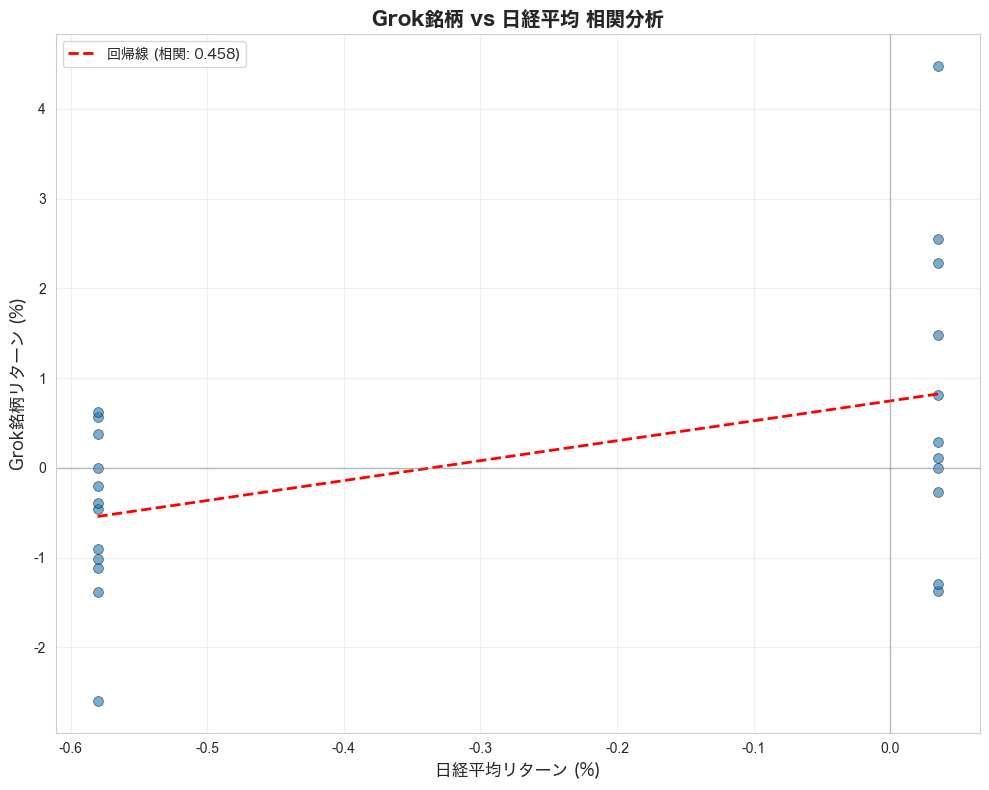

In [25]:
# 日経平均の日次リターンを取得
index_prices = loader.load_index_prices('1d')

# 日経平均のみ抽出
nikkei = index_prices[index_prices['ticker'] == '^N225'].copy()
nikkei['date'] = pd.to_datetime(nikkei['date']).dt.date
nikkei = nikkei.sort_values('date')
nikkei['nikkei_return'] = nikkei['Close'].pct_change(fill_method=None) * 100

# Grokデータと結合
archive['backtest_date'] = pd.to_datetime(archive['backtest_date']).dt.date
merged = archive.merge(nikkei[['date', 'nikkei_return']], 
                       left_on='backtest_date', right_on='date', how='left')

# phase1_returnをパーセント表示用に変換
merged['return_pct'] = merged['phase1_return'] * 100

# 相関分析
if 'nikkei_return' in merged.columns:
    valid_data = merged[['return_pct', 'nikkei_return']].dropna()
    
    if len(valid_data) > 0:
        correlation = valid_data['return_pct'].corr(valid_data['nikkei_return'])
        
        print(f"【日経平均との相関】")
        print(f"相関係数: {correlation:.3f}")
        
        # 散布図（フォント明示的指定）
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.scatter(valid_data['nikkei_return'], valid_data['return_pct'], 
                  alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # 回帰線
        z = np.polyfit(valid_data['nikkei_return'], valid_data['return_pct'], 1)
        p = np.poly1d(z)
        ax.plot(valid_data['nikkei_return'], p(valid_data['nikkei_return']), 
               "r--", linewidth=2, label=f'回帰線 (相関: {correlation:.3f})')
        
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlabel('日経平均リターン (%)', fontsize=12, fontfamily='Hiragino Sans')
        ax.set_ylabel('Grok銘柄リターン (%)', fontsize=12, fontfamily='Hiragino Sans')
        ax.set_title('Grok銘柄 vs 日経平均 相関分析', fontsize=14, fontweight='bold', fontfamily='Hiragino Sans')
        ax.legend(fontsize=11, prop={'family': 'Hiragino Sans'})
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../outputs/figures/grok_market_correlation.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("⚠️ 有効なデータがありません")
else:
    print("⚠️ 日経平均データとの結合に失敗")

## 7. プロンプト改善のための示唆

In [26]:
print("="*80)
print("プロンプト改善のための示唆")
print("="*80)

# 勝率・平均リターン
win_rate = (archive['phase1_win'] == True).mean() * 100
avg_return = archive['phase1_return'].mean() * 100

print(f"\n【現状パフォーマンス】")
print(f"勝率: {win_rate:.1f}%")
print(f"平均リターン: {avg_return:+.2f}%")

# 改善ポイント
print(f"\n【改善ポイント】")

print(f"\n1. マーケット環境の考慮")
if 'nikkei_return' in merged.columns and 'phase1_win' in merged.columns:
    market_up_days = merged[merged['nikkei_return'] > 0]
    market_down_days = merged[merged['nikkei_return'] < 0]
    
    if len(market_up_days) > 0:
        print(f"   - 上昇相場での勝率: {(market_up_days['phase1_win'] == True).mean()*100:.1f}%")
        print(f"   - 上昇相場での平均リターン: {market_up_days['phase1_return'].mean()*100:+.2f}%")
    if len(market_down_days) > 0:
        print(f"   - 下落相場での勝率: {(market_down_days['phase1_win'] == True).mean()*100:.1f}%")
        print(f"   - 下落相場での平均リターン: {market_down_days['phase1_return'].mean()*100:+.2f}%")

print(f"\n2. ボラティリティ分析")
print(f"   - 最大上昇率平均: {archive['max_gain_pct'].mean()*100:.2f}%")
print(f"   - 最大下落率平均: {archive['max_drawdown_pct'].mean()*100:.2f}%")

print("\n" + "="*80)

プロンプト改善のための示唆

【現状パフォーマンス】
勝率: 41.7%
平均リターン: +0.11%

【改善ポイント】

1. マーケット環境の考慮
   - 上昇相場での勝率: 58.3%
   - 上昇相場での平均リターン: +0.82%
   - 下落相場での勝率: 25.0%
   - 下落相場での平均リターン: -0.54%

2. ボラティリティ分析
   - 最大上昇率平均: 1.20%
   - 最大下落率平均: -1.07%



## 8. レポート出力

In [27]:
# 詳細レポート保存
report_data = {
    '総件数': len(archive),
    '勝率(%)': win_rate,
    '平均リターン(%)': avg_return,
    '勝ち件数': len(winners),
    '負け件数': len(losers),
    '勝ち平均リターン(%)': winners['phase1_return'].mean() * 100,
    '負け平均リターン(%)': losers['phase1_return'].mean() * 100,
}

report_df = pd.DataFrame([report_data])
report_df.to_csv('../outputs/reports/grok_pattern_analysis_summary.csv', index=False)

print("✓ レポート保存完了: outputs/reports/grok_pattern_analysis_summary.csv")
print("✓ グラフ保存完了: outputs/figures/grok_prompt_performance.png")
print("✓ グラフ保存完了: outputs/figures/grok_market_correlation.png")

✓ レポート保存完了: outputs/reports/grok_pattern_analysis_summary.csv
✓ グラフ保存完了: outputs/figures/grok_prompt_performance.png
✓ グラフ保存完了: outputs/figures/grok_market_correlation.png
